In [2]:
# add parenthesis to help with visually disambiguating order of operations
def fmt_label(l: str):
    if l == '':
        return '_'
    if len(l) > 1:
        return f"({l})"
    else:
        return l

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, _op={'Scalar' if self._op == '' else self._op}, label={'N/A' if self.label == '' else self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+', label=f"{fmt_label(self.label)}+{fmt_label(other.label)}")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*', label=f"{fmt_label(self.label)}*{fmt_label(other.label)}")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other

In [3]:
a = Value(5, label='a')
b = Value(3, label='b')
c = Value(7, label='c')
d = Value(2, label='d')

e = (a * b + c) * d

In [4]:
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [9]:
def traverse_values(node, make_node, make_edge):
    if not isinstance(node, Value):
        raise Exception('node is not Value')
    if not make_node:
        raise Exception('make_node must be defined')
    if not make_edge:
        raise Exception('make_edge must be defined')

    make_node(node)
    next = node._prev
    if next == ():
        return

    for x in next:
        make_edge(x.label, node.label)
        traverse_values(x, make_node, make_edge)

def draw_value(node: Value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    def make_node(n):
        dot.node(n.label, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    traverse_values(node, make_node=make_node, make_edge=lambda a, b: dot.edge(a, b))

    return dot

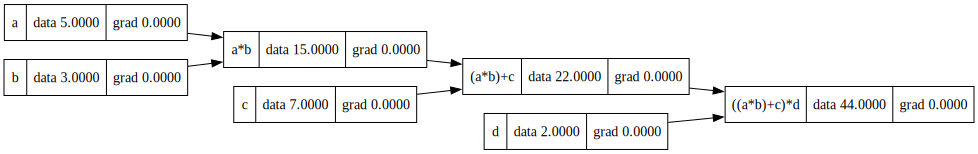

In [10]:
draw_value(e)